Import Necessary Libraries

In [16]:
# For numerical computations
import numpy as np
# For plotting the results
import matplotlib.pyplot as plt
# For displaying progress bars
from tqdm import trange

Define the Bandit Environment
The environment simulates the k-armed bandit, where each arm provides rewards based on a normal distribution with an unknown mean.

In [17]:
class BanditEnvironment:
    # Initialize the bandit environment
    def __init__(self, k_arm=10, true_reward=0.):
        self.k = k_arm
        self.true_reward = true_reward

    # Reset the environment by initializing the true action values
    def reset(self):
        # True action values are drawn from a normal distribution
        self.q_true = np.random.randn(self.k) + self.true_reward
        # Identify the best action
        self.best_action = np.argmax(self.q_true)

    # Take an action and return the corresponding reward
    def step(self, action):
        # Reward is drawn from a normal distribution centered at the true action value
        reward = np.random.randn() + self.q_true[action]
        return reward

Define the Epsilon-Greedy Agent
This agent selects actions based on the epsilon-greedy strategy, balancing exploration and exploitation.

In [18]:
class EpsilonGreedyAgent:
    # Initialize the epsilon-greedy agent
    def __init__(self, k_arm=10, epsilon=0.1, initial=0., step_size=0.1, sample_averages=False):
        self.k = k_arm
        self.epsilon = epsilon
        self.initial = initial
        self.step_size = step_size
        self.sample_averages = sample_averages

    def reset(self):
        # Reset the agent's estimations and counts
        self.q_estimation = np.zeros(self.k) + self.initial  # Estimated values
        self.action_count = np.zeros(self.k)                 # Count of actions taken
        self.indices = np.arange(self.k)                     # Action indices
        self.time = 0                                        # Time step

    # Select an action based on the epsilon-greedy strategy
    def act(self):
        if np.random.rand() < self.epsilon:
            # Explore: choose a random action
            return np.random.choice(self.indices)
        else:
            # Exploit: choose the action with the highest estimated value
            return np.argmax(self.q_estimation)

    # Update the estimated value of the selected action based on the received reward
    def learn(self, action, reward):
        self.time += 1
        self.action_count[action] += 1
        if self.sample_averages:
            # Update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        else:
            # Update estimation using a constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])


Define the Upper Confidence Bound (UCB) Agent
This agent selects actions based on the UCB algorithm, which balances exploration and exploitation using confidence bounds.

In [19]:
class UCBAgent:
    # Initialize the UCB agent
    def __init__(self, k_arm=10, c=2, initial=0., step_size=0.1, sample_averages=False):
        self.k = k_arm
        self.c = c
        self.initial = initial
        self.step_size = step_size
        self.sample_averages = sample_averages

    # Reset the agent's estimations and counts.
    def reset(self):
        self.q_estimation = np.zeros(self.k) + self.initial  # Estimated values
        self.action_count = np.zeros(self.k)                 # Count of actions taken
        self.indices = np.arange(self.k)                     # Action indices
        self.time = 0                                        # Time step

    # Select an action based on the UCB strategy
    def act(self):
        # Increment time step
        self.time += 1

        # For initial steps, select each action once to initialize counts
        if 0 in self.action_count:
            return np.argmin(self.action_count)
        else:
            # Calculate confidence bounds
            confidence_bounds = self.c * np.sqrt(np.log(self.time) / self.action_count)
            # Compute UCB values
            ucb_values = self.q_estimation + confidence_bounds
            # Select action with the highest UCB value
            return np.argmax(ucb_values)

    # Update the estimated value of the selected action based on the received reward
    def learn(self, action, reward):
        self.action_count[action] += 1
        if self.sample_averages:
            # Update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        else:
            # Update estimation using a constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])


Define the Simulation Function
The simulation runs multiple episodes, allowing us to compare the performance of different agents.

In [20]:
# Simulate the agents interacting with the environment
def simulate(runs, time, agents, environment):
    # Initialize arrays to store rewards and optimal action counts
    rewards = np.zeros((len(agents), runs, time))
    best_action_counts = np.zeros_like(rewards)

    # Loop over each run
    for r in trange(runs, desc='Simulating Runs'):
        # Reset the environment once per run so all agents face the same environment
        environment.reset()

        # Loop over each agent
        for i, agent in enumerate(agents):
            # Reset the agent
            agent.reset()

            # Loop over each time step
            for t in range(time):
                # Agent selects an action
                action = agent.act()
                # Environment returns a reward
                reward = environment.step(action)
                # Agent learns from the reward
                agent.learn(action, reward)

                # Store the reward obtained
                rewards[i, r, t] = reward
                # Check if the selected action was the best action
                if action == environment.best_action:
                    best_action_counts[i, r, t] = 1

    # Calculate mean rewards and optimal action selection percentages
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards


Define the Plotting Function
This function runs the simulation and plots the average reward over time for each agent.

In [21]:
# Simulate the agents and plot the average reward over time
def figure_2_4(runs=2000, time=1000):
    # Initialize the environment
    environment = BanditEnvironment()

    # Initialize the agents
    agents = [
        UCBAgent(k_arm=10, c=2, sample_averages=True),
        EpsilonGreedyAgent(k_arm=10, epsilon=0.1, sample_averages=True)
    ]

    # Run the simulation
    _, average_rewards = simulate(runs, time, agents, environment)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(average_rewards[0], label='UCB $c = 2$', color='blue')
    plt.plot(average_rewards[1], label=r'$\epsilon$-greedy $\epsilon = 0.1$', color='gray')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()
    plt.title('Average Reward over Steps')
    plt.grid(True)
    
    # Save the plot as a PNG file
    plt.savefig('Figure 2.4.png')
    plt.show()


Run the Simulation and Plot Results:
Simulate and visualize two agent's performance

Simulating Runs: 100%|██████████| 2000/2000 [02:18<00:00, 14.46it/s]


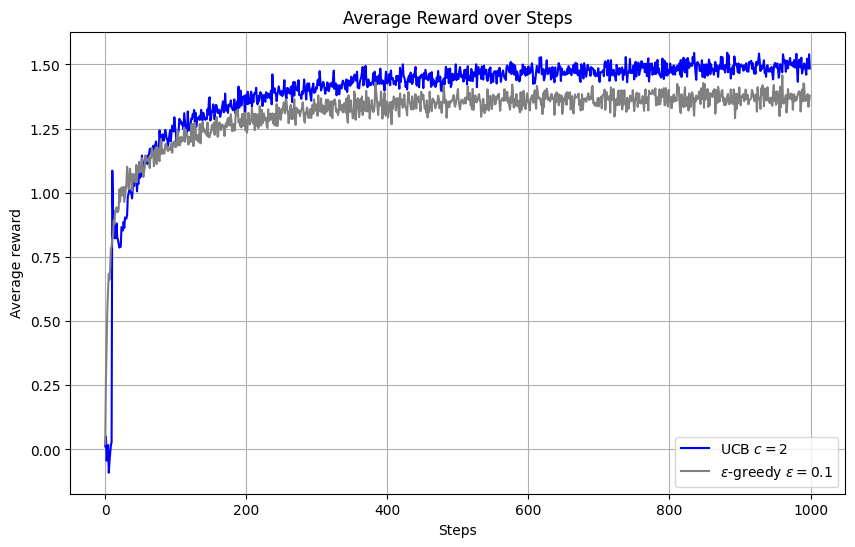

In [22]:
figure_2_4()